<a href="https://colab.research.google.com/github/DavidScanu/cas-pratique-reconnaissance-iris/blob/main/notebooks/reconnaissance_iris_id_classifier_left_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://img.freepik.com/free-photo/magnified-single-yellow-fish-eye-with-abstract-pattern-generated-by-ai_188544-9714.jpg"></img>

# Cas Pratique : Reconnaissance d'iris - Part 2 : Détection id employé (oeil gauche)

**David Scanu** - Normand'IA 2023-2024

---

Vous êtes un développeur IA, votre entreprise vous a confié la mission de **développer une interface de reconnaissance d’oeil pour une entreprise souhaitant authentifier ses 45 employés** à partir d’un scan de leurs yeux.

---

## Partie 2 : Classification ID Employé (oeil gauche)

Développement d'un **classificateur** qui retrouve l'identifiant d'un employé à partir de l'image de son oeil gauche.

---
## Améliorations possible :

- Ajouter MLFlow
- Ajouter Tensorboard



---

## TODO

- Problème : 44 n'est pas prédit dans y_pred (à démêler avec to_categorical, 47 colonnes dans le vecteur), pose des problèmes pour le F1 Score.
- Matrice de confusion : afficher plus grande et pourquoi 0 et 4 sont dedans alors que ces cibles n'existent pas
- Tout en bas : créer une liste des requirements

---

## Etapes de développement du modèle

- Import des bibliothèques
- Connection à Google Drive
- Importation des images depuis Google Drive
- Variables principales
- Construction du jeu de données
- One-Hot Encoding des labels
- Augmentation des données (Data Augmentation)
- Prétraitement des images (redimensionnement et mise à l'échelle)
- Fonctions de callbacks pour l'entraînement
- Architecture du modèle
- Entrainement du modèle
- Sauvegarde du modèle
- Importer le modèle et le label encoder
- Prédictions avec les données de test
- Affichage des performances
- Inférence avec une image
- Montrer les images mal classées

## Import des bibliothèques

In [1]:
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from keras import regularizers
from tensorflow.keras import layers
from PIL import Image
import cv2
import datetime
import shutil

## Connection à Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Importation des images depuis Google Drive

In [3]:
!unzip -qq "/content/drive/MyDrive/Microsoft IA Simplon ISEN/Passage-titre/Cas pratique 01 - Reconnaissance iris/consignes/MMU-Iris-Database.zip"

## Variables principales

In [42]:
SIDE = 'left'
TRAIN = False
EPOCHS = 50

In [5]:
backup_folder = '/content/drive/MyDrive/Microsoft IA Simplon ISEN/Passage-titre/Cas pratique 01 - Reconnaissance iris/notebooks/02-id-classifier/'

In [6]:
# Images are 320px width, 240px height and 3 color layers deep (RVB)
img_width = 320
img_height = 240
img_channels = 3
img_dim = (img_height, img_width, img_channels)

## Construction du dataset


### Split du dataset dans un nouveau dossier

L'objectif est de construire un nouveau dossier `MMU-Iris-Database-split/` contenant deux sous-dossiers : `train/` et `test/`.

Exemples :
- `MMU-Iris-Database-split/train/1/left/image01.bmp`
- `MMU-Iris-Database-split/test/32/right/image03.bmp`

In [7]:
# Chemin vers le dossier principal contenant les sous-dossiers
og_dataset_folder_path = '/content/MMU-Iris-Database/'
new_dataset_folder_path = '/content/MMU-Iris-Database-split/'

In [8]:
# @title Fonctions d'aide : création et supression de dossiers

def make_folder(folder_path):
  if not os.path.isdir(folder_path):
    os.mkdir(folder_path)

def make_subfolder(folder_path, subfolder_name):
  subfolder_path = folder_path + subfolder_name  + '/'
  if not os.path.isdir(subfolder_path):
    os.mkdir(subfolder_path)
  return subfolder_path

def delete_folder(folder_path):
  if os.path.isdir(folder_path):
    try:
        shutil.rmtree(folder_path)
        # print('Folder and its content removed')
    except:
        print('Folder not deleted')

In [9]:
# @title Fonction qui split le dataset en dossier 'train' et dossier 'test'

def make_train_test_folders(og_dataset_folder_path, new_dataset_folder_path, train_size=0.8, random_state=42):
  """
  Fonction qui split le dataset en dossier 'train' et dossier 'test'. Utile pour
  avoir toujours le même split dans les 3 notebooks. De cette manière, nous sommes
  sur qu'une image de test n'est jamais passée dans les données d'entrainement.

  Retourne les chemins vers les dossiers : 'train' et 'test'.
  """
  # Effacer le dossier et tous ses sous-dossiers, s'il existe déjà
  delete_folder(new_dataset_folder_path)
  # Créer le nouveau dossier pour le nouveau dataset, s'il n'existe pas déjà
  make_folder(new_dataset_folder_path)

  # Créer les sous-dossier 'train' et 'test'
  new_train_folder_path = make_subfolder(new_dataset_folder_path, 'train')
  new_test_folder_path = make_subfolder(new_dataset_folder_path, 'test')

  # Parcourir le dossier source
  for id in os.listdir(og_dataset_folder_path):
    og_id_path = os.path.join(og_dataset_folder_path, id)
    if os.path.isdir(og_id_path):
      # Dans le dossier de destination, créer 'train/*id*' et 'train/*id*'
      new_train_id_subfolder = make_subfolder(new_train_folder_path, id)
      new_test_id_subfolder = make_subfolder(new_test_folder_path, id)
      for side in os.listdir(og_id_path):
        og_side_path = os.path.join(og_id_path, side)
        if os.path.isdir(og_side_path):
          # Créer le nouveau dossier 'train/{id}/{side}'
          new_train_id_side_subfolder = make_subfolder(new_train_id_subfolder, side)
          # Créer le nouveau dossier 'test/{id}/{side}'
          new_test_id_side_subfolder= make_subfolder(new_test_id_subfolder, side)
          # Parcourir le dossier original : {id}/{side}/
          # Ajouter à la liste uniquement les fichiers '.bmp', '.jpg', '.png'
          og_images_list = [f for f in os.listdir(og_side_path) if f.lower().endswith(('.bmp', '.jpg', '.png'))]
          # Mélanger la liste d'images
          random.Random(random_state).shuffle(og_images_list)
          # Split les images en train et test
          ratio = train_size
          total_rows = len(og_images_list)
          train_size_rows = int(total_rows * ratio)
          train_imgs = og_images_list[0:train_size_rows]
          test = og_images_list[train_size_rows:]
          # Copier les images dans le nouveau dossier 'train'
          for image_filename in train_imgs:
            og_image_path = os.path.join(og_side_path, image_filename)
            shutil.copy2(og_image_path, new_train_id_side_subfolder)
          # Copier les images dans le nouveau dossier 'test'
          for image_filename in test:
            og_image_path = os.path.join(og_side_path, image_filename)
            shutil.copy2(og_image_path, new_test_id_side_subfolder)

  return new_train_folder_path, new_test_folder_path

In [10]:
# Création du nouveau dossier contenant les dossiers : 'train' et 'test'
new_train_folder_path, new_test_folder_path = make_train_test_folders(og_dataset_folder_path, new_dataset_folder_path)

In [11]:
print(new_train_folder_path)
print(new_test_folder_path)

/content/MMU-Iris-Database-split/train/
/content/MMU-Iris-Database-split/test/


### Création du dataset

In [12]:
def make_dataset_id_side(folder, side):
  """
  Fonction qui retourne :
  - Variable X : Liste des images (liste de ndarray)
  - Variable y : Liste des IDs des employés dans la variable cible y (liste de int)
  + sélection du coté de l'oeil choisi pour l'entrainement ('left' ou 'right').
  """
  X = []
  y = []

  for id_folder in os.listdir(folder):
    target_path = os.path.join(folder, id_folder)
    if os.path.isdir(target_path):
      side_path = os.path.join(target_path, side)
      if os.path.isdir(side_path):
        for image_filename in os.listdir(side_path):
          if image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
            image_path = os.path.join(side_path, image_filename)
            image = cv2.imread(image_path)
            target = int(id_folder)
            X.append(image) # list
            y.append(target) # list
  # Convertit les listes en ndarray
  X = np.array(X)
  y = np.array(y)
  return X, y

In [13]:
# Création des datasets d'entrainement et de test
X_train, y_train = make_dataset_id_side(new_train_folder_path, SIDE)
X_test, y_test = make_dataset_id_side(new_test_folder_path, SIDE)

In [14]:
print(f"Dimensions des images d'entrainement : {X_train.shape}.")
print(f"Dimensions des labels d'entrainement : {y_train.shape}.")
print(f"Dimensions des images de test : {X_test.shape}.")
print(f"Dimensions des labels de test : {y_test.shape}.")

Dimensions des images d'entrainement : (180, 240, 320, 3).
Dimensions des labels d'entrainement : (180,).
Dimensions des images de test : (45, 240, 320, 3).
Dimensions des labels de test : (45,).


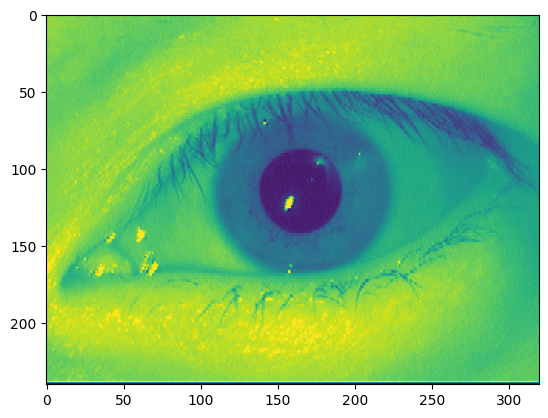

In [15]:
# Exemple d'une image d'entrainement
plt.imshow(X_train[0][:,:,2])

## One-Hot Encoding des labels des classes (IDs employés)

Convertit un vecteur de classes (entiers) en matrice de classes binaire.

- https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [16]:
# Toutes les valeurs possibles de y_train
print(set(y_train))

{1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46}


In [17]:
y_train.shape

(180,)

In [18]:
y_train[0]

38

In [19]:
from keras.utils import to_categorical

# To categorical
y_train_vect = to_categorical(y_train, dtype ="int32")
# y_test_vect = to_categorical(y_test) # pas besoin des cibles de test sous forme de vecteurs

In [20]:
y_train_vect.shape

(180, 47)

In [21]:
# Un exemple de cible au format vecteur
y_train_vect[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0], dtype=int32)

## Augmentation des données (Data Augmentation)

L'augmentation des données est une technique qui permet de créer artificiellement de nouvelles données à partir d'un ensemble de données existant. Ces nouvelles données sont générées en appliquant des transformations mineures aux données existantes, ou en utilisant d'autres modèles d'apprentissage automatique.

- https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr
- https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

In [23]:
# Creation d'une instance de ImageDataGenerator
# On applique les transformations souhaitées sur l'image
datagen = ImageDataGenerator(
  rotation_range=7,
  width_shift_range=0.1,
  height_shift_range=0.1,
  brightness_range=[0.5, 1.2],
  zoom_range=0.1,
  channel_shift_range=0.1,
  fill_mode='wrap' # reflect
)

In [24]:
def augment_dataset(X_train, y_train, nb_aug_imgs):
  """
  Retourne un ndarray d'images augmentées utilisant 'datagen' (l'instance
  de la classe ImageDataGenerator) et leurs labels associés.
  """
  # Convertit les ndarray en listes
  if isinstance(X_train, np.ndarray):
    X_train = X_train.tolist()
  if isinstance(y_train, np.ndarray):
    y_train = y_train.tolist()

  augmented_images = []
  augmented_labels = []
  for img, label in zip(X_train, y_train) :
    # Ajoute une dimension supplémentaire au Tensor
    img = np.expand_dims(img, axis=0)
    # img = tf.cast(tf.expand_dims(ex_img, 0), tf.float32)
    # Compte le nombre d'itérations de la boucle
    batches = 0
    # Applique le ImageDataGenerator à l'image
    for batch in datagen.flow(img, batch_size=1):
        augmented_images.append(batch[0])
        augmented_labels.append(label)
        batches += 1
        # Generer un nombre d'images puis sortir de la boucle
        if batches >= nb_aug_imgs:
          break
  augmented_images = np.array(augmented_images)
  augmented_labels = np.array(augmented_labels)
  return augmented_images, augmented_labels

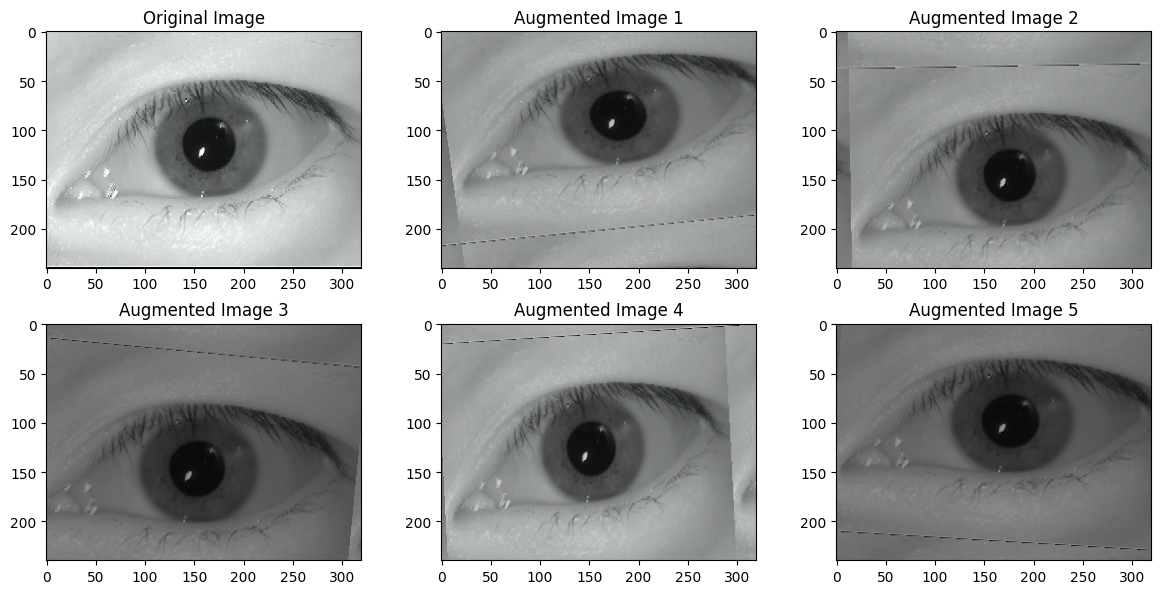

In [25]:
# Visualisation d'un exemple d'image
img = tf.cast(tf.expand_dims(X_train[0], 0), tf.float32)
aug_ex_imgs, aug_ex_labels = augment_dataset(X_train[:1], y_train_vect[:1], 5)

# Display original and augmented images using matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(2, 3, 1)
# plt.imshow(np.array(img[0]))
plt.imshow(img[0].astype(np.uint8)) # Les valeurs des pixels doivent être des entiers et non des nombres décimaux
plt.title('Original Image')

for i, augmented_img in enumerate(aug_ex_imgs):
    plt.subplot(2, 3, i + 2)
    plt.imshow(augmented_img.astype(np.uint8))
    plt.title(f'Augmented Image {i+1}')

plt.tight_layout()
plt.show()

### Augmentation des images d'entrainement

- https://sparkbyexamples.com/numpy/numpy-concatenate-arrays/

In [26]:
# Géneration des images augmentées
augmented_images, augmented_labels = augment_dataset(X_train, y_train_vect, 5)

In [27]:
# Ajout des images augmentées aux images d'entrainement
X_train_aug = np.concatenate((X_train, augmented_images))
y_train_aug = np.concatenate((y_train_vect, augmented_labels))

In [28]:
X_train_aug.shape

(1080, 240, 320, 3)

In [29]:
y_train_aug.shape

(1080, 47)

### Augmentation des images de test

In [30]:
# Data augmentation des images de test
imgs_test_aug, labels_test_aug = augment_dataset(X_test, y_test, 5)

# Ajout des images augmentées aux images de test
X_test_aug = np.concatenate((X_test, imgs_test_aug))
y_test_aug = np.concatenate((y_test, labels_test_aug))

In [31]:
X_test_aug.shape

(270, 240, 320, 3)

In [32]:
y_test_aug.shape

(270,)

## Prétraitement de l'image : redimensionnemennt et mise à l'échelle

Les couches de prétraitement des images seront ajoutées aux couches du modèle, juste après la couche Input. Ces couches seront inclues dans le modèle, évitant ainsi de devoir les exporter séparemment.

- https://www.tensorflow.org/tutorials/images/data_augmentation?hl=fr#resizing_and_rescaling
- https://www.tensorflow.org/guide/keras/preprocessing_layers
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Resizing
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/Rescaling
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/CenterCrop

In [33]:
# Couche de redimensionnement d'images
resizing_layer = tf.keras.layers.Resizing(
  img_height,
  img_width,
  interpolation='bilinear',
  crop_to_aspect_ratio=True
)

In [34]:
# Couche de normalisation d'images
rescaling_layer = tf.keras.layers.Rescaling(scale=1./255)

In [35]:
# Visualisation d'une image d'exemple
ex_img = X_train[7]
print(f"Shape de l'image : {ex_img.shape}")

Shape de l'image : (240, 320, 3)


In [36]:
# Redimensionnement de l'image
ex_img_resized = resizing_layer(ex_img)

In [37]:
# Mise à l'échelle de l'image (valeurs des pixels entre 0 et 1)
ex_img_resized_and_rescaled = rescaling_layer(ex_img_resized)

In [38]:
print(f"Shape de l'image redimensionnée et normalisée : {ex_img_resized_and_rescaled.shape}")

Shape de l'image redimensionnée et normalisée : (240, 320, 3)


In [39]:
# Verify that the pixels are in the [0, 1] range:
print("Valeurs minimum des pixels :", ex_img_resized_and_rescaled.numpy().min())
print("Valeurs maximum des pixels :", ex_img_resized_and_rescaled.numpy().max())

Valeurs minimum des pixels : 0.0
Valeurs maximum des pixels : 0.9725491


## Fonctions de callbacks pour l'entrainement

**ReduceLROnPlateau** : Ce callback permet de réduire le taux d'apprentissage si une métrique surveillée (généralement la perte de validation) ne s'améliore pas pendant un certain nombre d'époques. Cela peut aider à empêcher le modèle de se sur-adapter (over-fit) aux données d'entraînement.

**EarlyStopping** : Ce callback permet d'arrêter l'entraînement du modèle si une métrique surveillée ne s'améliore pas pendant un certain nombre d'époques. Cela peut aider à économiser du temps de calcul et à empêcher le modèle de se sur-adapter aux données d'entraînement.

In [40]:
!pip install livelossplot --quiet

In [41]:
# Live training loss plot
# Log-loss (cost function) and accuracy
from livelossplot import PlotLossesKeras

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
rlrop = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3)
early = EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)

## Architecture du modèle

`functional API` de Keras permet de créer des modèles qui sont plus flexibles qu'avec `Sequential API`. `functional API` peut accepter des modèles non-linaires, avec des couches partagées, ou même avec des entrées et sorties multiples.

L’idée principale est qu’un modèle d’apprentissage profond est généralement un `directed acyclic graph (DAG)` de couches. `functional API` est donc un moyen de créer des graphiques de couches.

- https://keras.io/guides/functional_api/
- https://keras.io/api/models/model/#model-class
- https://keras.io/api/layers/core_layers/input/
- https://stackoverflow.com/questions/44747343/keras-input-explanation-input-shape-units-batch-size-dim-etc
- https://ressources.labomedia.org/keras_input_explanation

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Input, Lambda, Dense, Flatten

# Nombre de classes uniques
NBCLASSES = y_train_aug.shape[1]

def create_model():

  # Couche d'entrée des images
  # La couche Input converti les données d'entrée en Keras tensor.
  # L'argument 'shape' ne doit pas inclure la dimension du batch (le nombre d'images)
  # La valeur '[None, None]' permet de passer une taille d'images libre, elles seront redimensionnées par la couche suivante
  inputs = Input(shape=[None, None] + [img_channels])

  # Pré-traitement des images
  # Ajoute la couche de redimensionnement
  imgs_resized = resizing_layer(inputs)
  # Ajoute la couche de normalisation
  imgs_rescaled = rescaling_layer(imgs_resized)

  # Ajoute le modèle VGG16, pré-entrainé sur ImageNet
  # vgg = VGG16(input_shape=(img_height, img_width, img_depth), weights='imagenet', include_top=False)
  vgg = VGG16(
    include_top=False,
    weights="imagenet",
    input_tensor=imgs_rescaled, # Tenseur Keras facultatif (c'est-à-dire la sortie du layer.Input()) à utiliser comme entrée d'image pour le modèle.
    input_shape=(img_height, img_width, img_channels)
  )
  # Gèle des couches VGG avec les poids pré-entrainés
  for layer in vgg.layers:
      layer.trainable = False
  # Récupère la sortie de VGG
  vgg_out = vgg.output

  # Ajoute une couche Dense pour nos classes de sorties
  x = Flatten()(vgg_out)
  outputs = Dense(NBCLASSES, activation='softmax')(x)

  # Création du modèle
  model = Model(inputs=inputs, outputs=outputs, name="id_left_vgg16_imagenet_model")
  model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=['accuracy'])
  model.summary()
  return model

id_left_classifier = create_model()

58889256/58889256 [==============================] - 0s 0us/step
Model: "id_left_vgg16_imagenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 240, 320, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                       

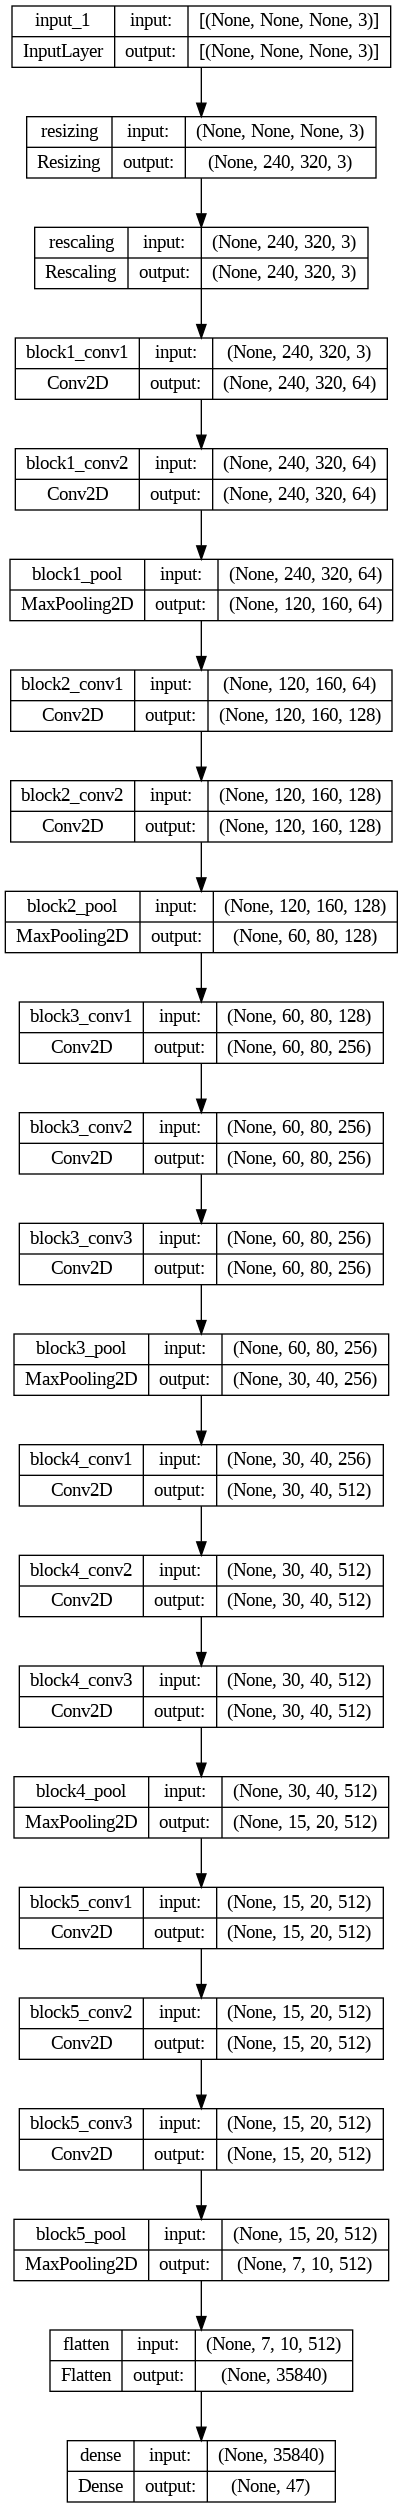

In [ ]:
# Affiche l'architecture du modèle avec les dimensions en entrée et sortie de chaque couche
tf.keras.utils.plot_model(id_left_classifier, "id_left_classifier_model_with_shape_info.png", show_shapes=True)

## Entrainement du modèle

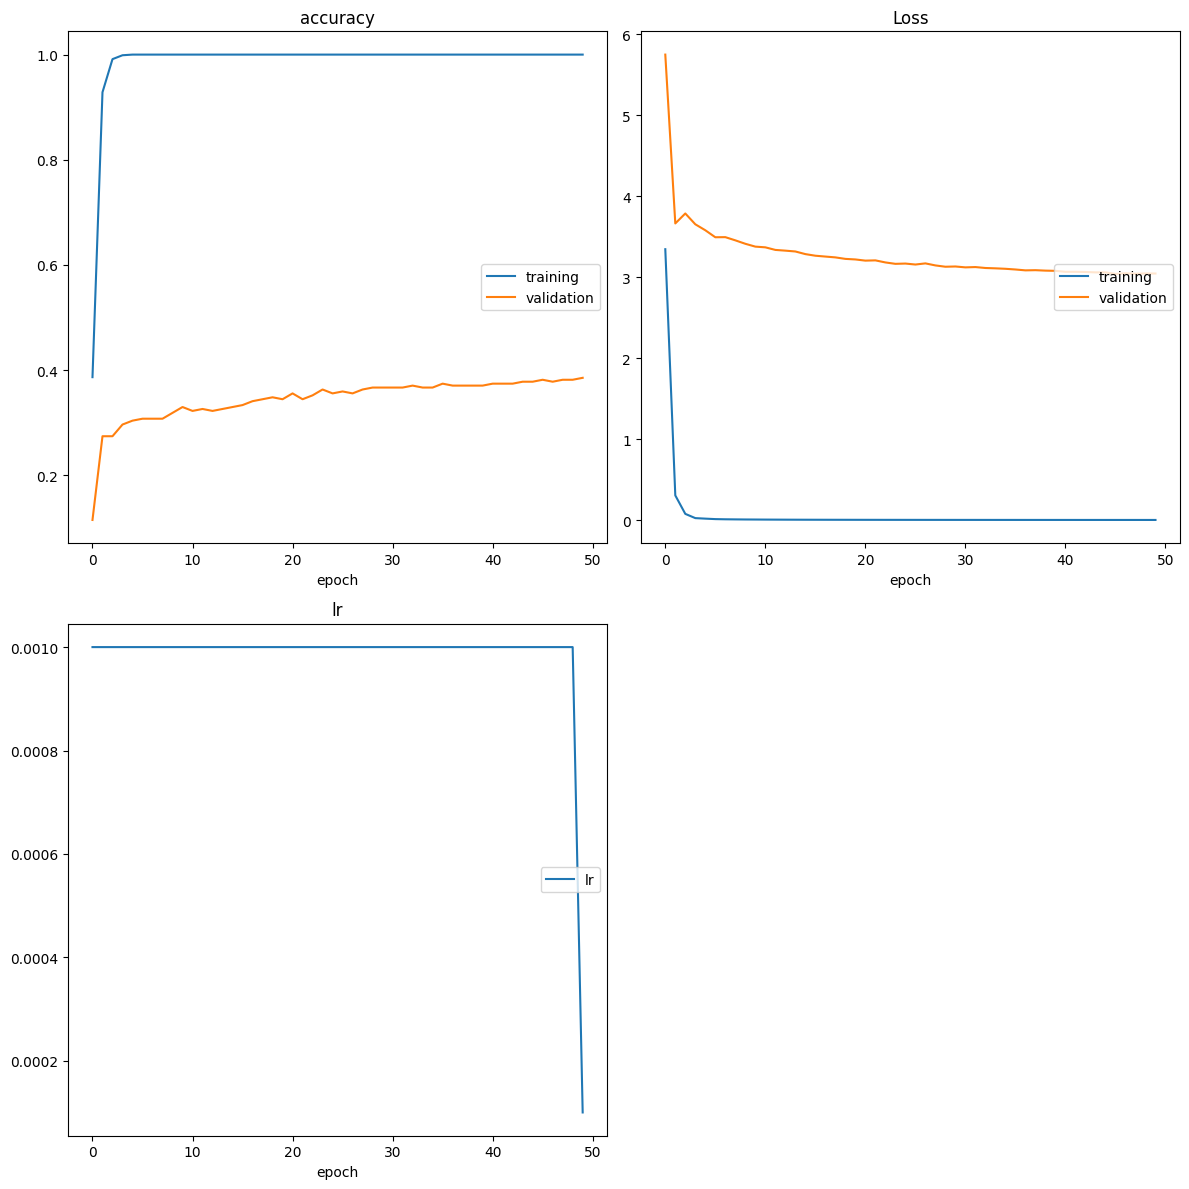

accuracy
	training         	 (min:    0.386, max:    1.000, cur:    1.000)
	validation       	 (min:    0.115, max:    0.385, cur:    0.385)
Loss
	training         	 (min:    0.001, max:    3.346, cur:    0.001)
	validation       	 (min:    3.041, max:    5.751, cur:    3.046)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)
27/27 [==============================] - 9s 332ms/step - loss: 5.9704e-04 - accuracy: 1.0000 - val_loss: 3.0457 - val_accuracy: 0.3852 - lr: 1.0000e-04


In [ ]:
if TRAIN:
  id_left_classifier_hist = id_left_classifier.fit(
    X_train_aug,
    y_train_aug,
    batch_size = 30,
    epochs = EPOCHS,
    validation_split=0.25,
    callbacks=[rlrop, early, PlotLossesKeras()]
  )

In [ ]:
print(id_left_classifier_hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


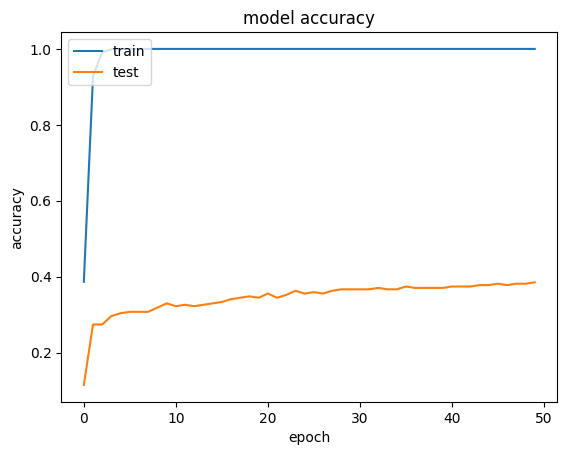

In [ ]:
# summarize history for accuracy
plt.plot(id_left_classifier_hist.history['accuracy'])
plt.plot(id_left_classifier_hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

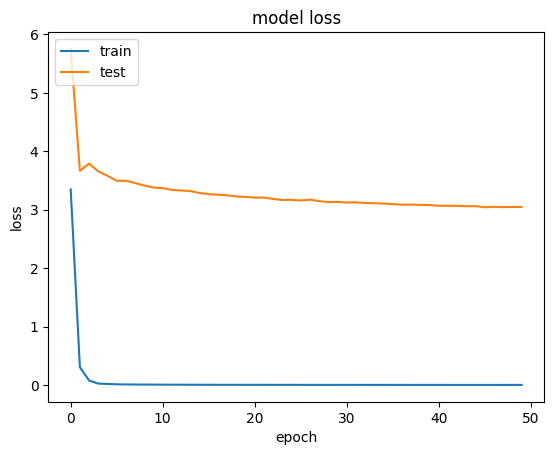

In [ ]:
# summarize history for loss
plt.plot(id_left_classifier_hist.history['loss'])
plt.plot(id_left_classifier_hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Sauvegarde du modèle

- https://keras.io/api/saving/model_saving_and_loading/
- https://www.tensorflow.org/guide/keras/serialization_and_saving

In [43]:
id_left_classifier_path = backup_folder + "id_left_classifier.h5"

In [ ]:
if TRAIN :
  id_left_classifier.save(id_left_classifier_path)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Charger le classifier et label encoder

In [44]:
# Importer le modèle 'ID Left Classifier'
id_left_classifier_loaded = tf.keras.models.load_model(id_left_classifier_path)
id_left_classifier_loaded.summary()

Model: "id_left_vgg16_imagenet_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 resizing (Resizing)         (None, 240, 320, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 240, 320, 3)       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 240, 320, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 240, 320, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 120, 160, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 12

## Prédictions avec les données de test (augmentées)

In [45]:
# Prédictions du modèle
y_pred = np.argmax(id_left_classifier_loaded.predict(X_test_aug), axis=1)

9/9 [==============================] - 20s 635ms/step


## Performances

### Matrice de confusion

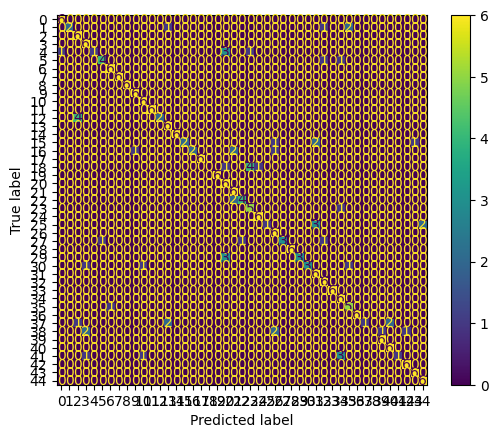

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Calcul de la matrice de confusion
conf_matrix = confusion_matrix(y_test_aug, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

### Métriques

Quel est la métrique la plus importante dans cette tache de classification ?

In [47]:
# One-Hot Encoding des cibles de test (qui étaient restées au format encodées)
y_test_aug_to_cat = to_categorical(y_test_aug)

In [48]:
loss, acc = id_left_classifier_loaded.evaluate(X_test_aug, y_test_aug_to_cat, verbose=2)
print('Restored model, accuracy: {:5.2f}%'.format(100 * acc))

9/9 - 3s - loss: 1.3506 - accuracy: 0.7667 - 3s/epoch - 342ms/step
Restored model, accuracy: 76.67%


In [49]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calcul des mesures de performance
precision = precision_score(y_test_aug, y_pred, average='macro', zero_division=0)
recall = recall_score(y_test_aug, y_pred,average='macro')
f1 = f1_score(y_test_aug, y_pred,average='macro')
accuracy = accuracy_score(y_test_aug, y_pred)

print("Accuracy : {:.2f}".format(accuracy))
print("Précision : {:.2f}".format(precision))
print("Rappel : {:.2f}".format(recall))
print("Score F1 : {:.2f}".format(f1))

Accuracy : 0.77
Précision : 0.80
Rappel : 0.77
Score F1 : 0.72


## Inférence avec une image

### Fonction pour la prédiction (inférence)

Cette fonction servira pour réaliser les prédictions dans l'application Streamlit.

In [51]:
def lr_inference(image_file):
  """
  Fonction qui réalise une prédiction à partir d'un fichier image (ndarray ou PIL Image).
  """
  # Ajout d'une dimension car le modèle accepte une liste d'images cad un objet à 4 dimensions.
  image_file_more_dims = np.expand_dims(image_file, axis=0)
  # Inférence
  pred = np.argmax(id_left_classifier_loaded.predict(image_file_more_dims), axis=1)[0]
  # Retourne une string
  return pred

### Selection d'une image de test

In [ ]:
def get_test_images_paths(folder_path, id, side) -> list:
  """
  Function qui retourne une liste de chemins vers des images de test en fonction de l'ID et du coté choisi.
  """
  test_image_folder_path = folder_path + f'{id}/{side}/'
  test_images_path_list = []
  for test_image_filename in os.listdir(test_image_folder_path):
    if test_image_filename.lower().endswith(('.bmp', '.jpg', '.png')):
      test_image_path = test_image_folder_path + test_image_filename
      test_images_path_list.append(test_image_path)
  return test_images_path_list

In [ ]:
test_image_path = get_test_images_paths(new_test_folder_path, 26, SIDE)[0]

### PIL

In [ ]:
# PIL
test_img_pil = Image.open(test_image_path)
print(f"Format : {test_img_pil.format}")
print(f"Mode : {test_img_pil.mode}")
print(f"Size : {test_img_pil.size}")

Format : BMP
Mode : RGB
Size : (320, 240)


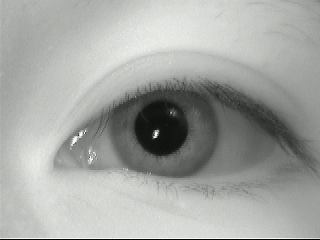

In [ ]:
test_img_pil

In [ ]:
lr_inference(test_img_pil)

1/1 [==============================] - 1s 783ms/step


26

### cv2

In [ ]:
# cv2
test_img_cv2 = cv2.imread(test_image_path)

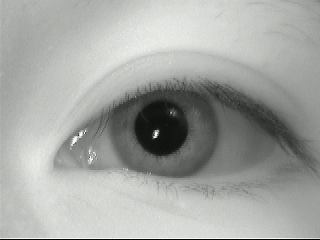

In [ ]:
from google.colab.patches import cv2_imshow
cv2_imshow(test_img_cv2)

In [ ]:
lr_inference(test_img_cv2)

1/1 [==============================] - 0s 20ms/step


26

## Montrer les images mal classées

In [ ]:
# Images mal classées
missed_imgs = X_test_aug[y_pred != y_test_aug]
# Prédiction du classifieur
missed_pred = np.array(y_pred)[y_pred != y_test_aug]
# Réalité terrain
missed_truth = y_test_aug[y_pred != y_test_aug]

In [ ]:
# Prédiction du classifieur
missed_pred

array([25, 44, 36, 24, 24, 37,  5, 36, 36, 22, 15, 15, 35, 15, 15,  5,  5,
       15,  5, 12, 37, 37,  3,  3,  3,  3,  1, 25, 34, 22, 25, 35, 22, 25,
       37, 46, 30, 34, 33, 11, 28, 23, 28,  5, 23, 24, 23, 12, 21, 15, 22,
       22, 22, 22, 44, 28, 30, 44, 44,  5,  3, 42,  3])

In [ ]:
# Réalité terrain
missed_truth

array([20, 40, 16, 12, 12, 12, 44, 25,  7, 26,  2,  2,  2,  2,  2, 29, 29,
       29, 29, 43, 43, 43, 14, 14, 14, 14,  6,  6,  6,  6, 20, 20, 20, 20,
       20, 27, 27, 27, 27, 18, 18, 18, 18, 17, 17, 17, 17, 32, 32, 32, 31,
       31, 31, 31, 40, 40, 40, 40, 40, 39, 39, 39, 39])

In [ ]:
# Compte des images mal classées
missed_imgs_count = int(len(missed_imgs))
print(f"Il y a {missed_imgs_count} images pour lesquelles le classificateur se trompe.")

Il y a 63 images pour lesquelles le classificateur se trompe.


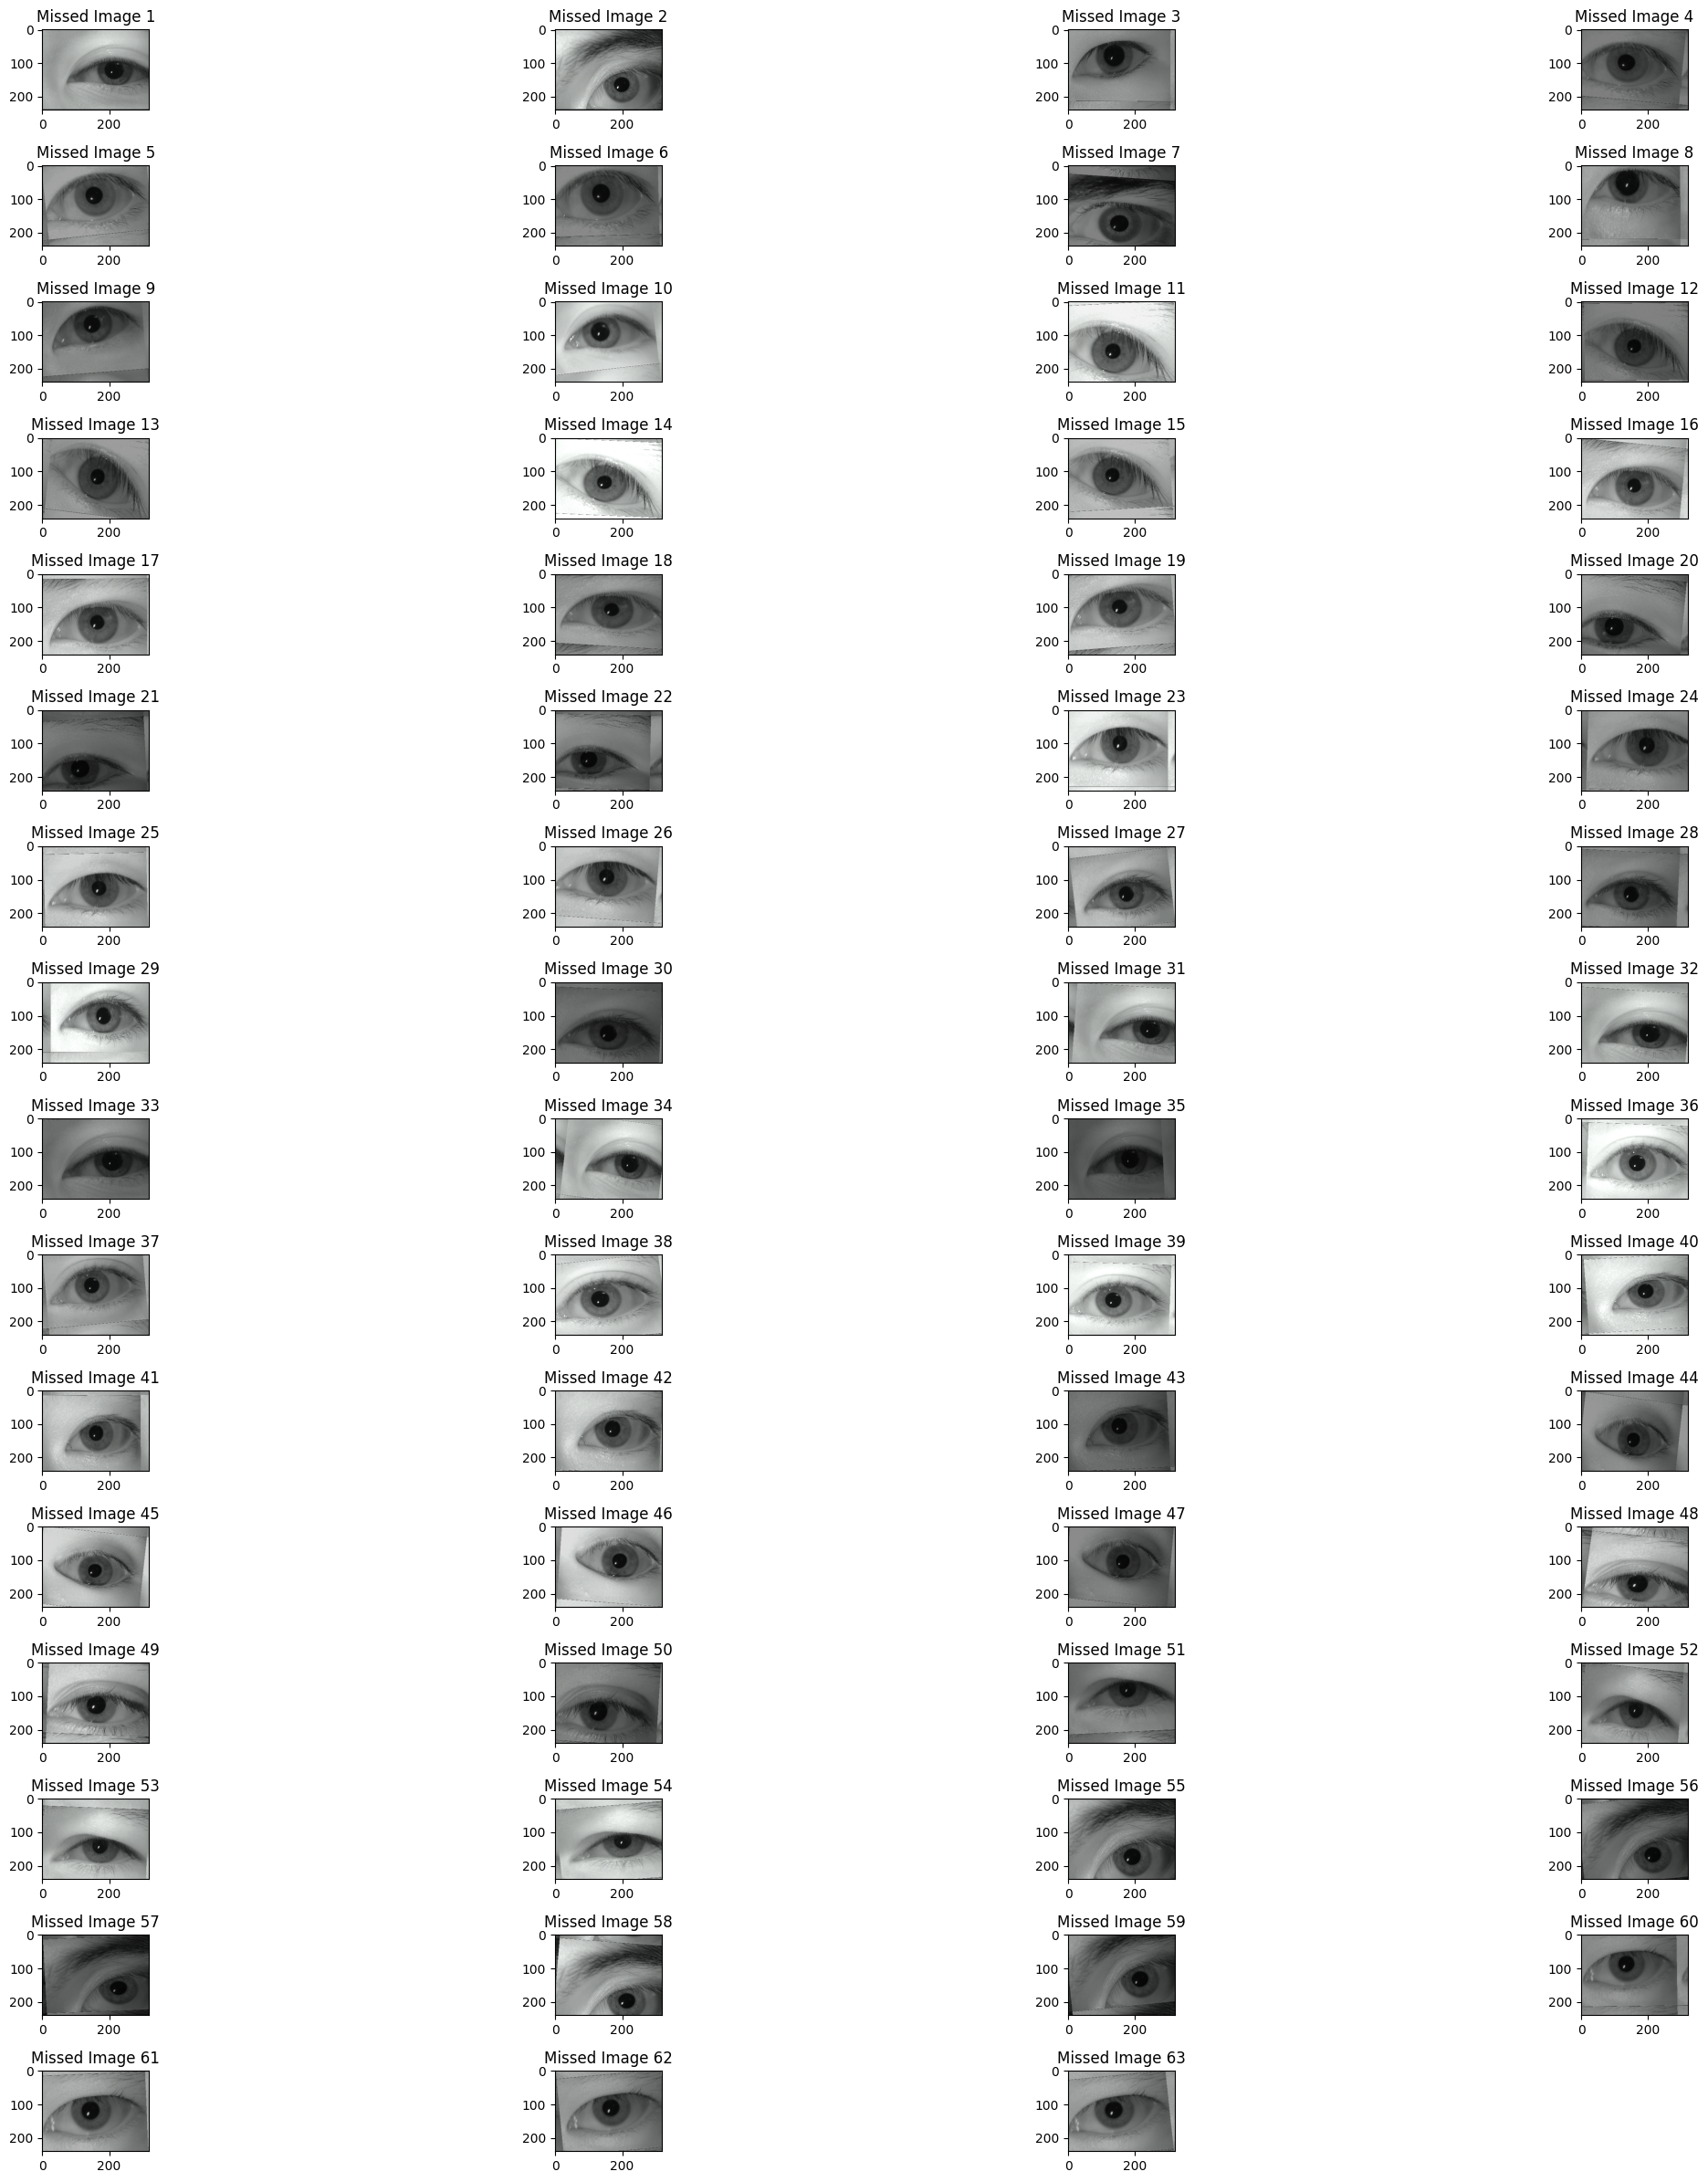

In [ ]:
import math

# Montrer les images mal classées
cols = 4
rows = math.ceil(missed_imgs_count / cols)
plt.figure(figsize=(24, 24))
for i, img in enumerate(missed_imgs):
  plt.subplot(rows, cols, i + 1)
  plt.imshow(img.astype(np.uint8))
  plt.title(f'Missed Image {i+1}')
plt.tight_layout()
plt.show()